In [1]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# import osmnx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geojson
import shapely

/Users/fabian/Documents/GitHub/osm-times-of-crisis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Use Geocode to convert a place name to a polygon, then a list of coordinates that represent the boundary of the relation

<class 'shapely.geometry.multipolygon.MultiPolygon'>
5 Polygons in Geometry


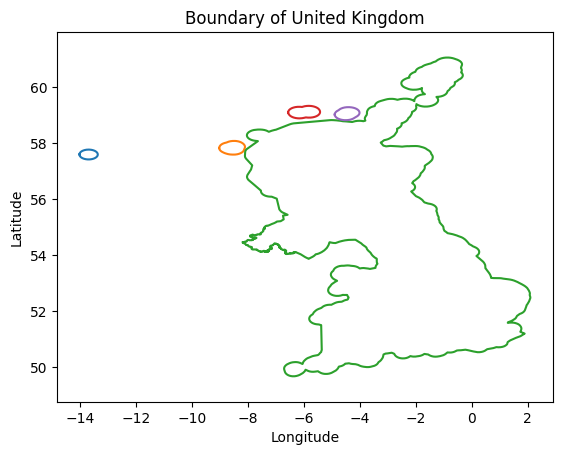

<Axes: >

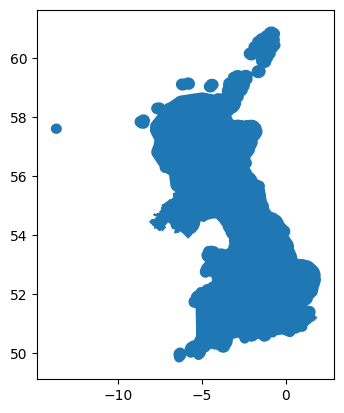

In [5]:
# Specify the name that we want to geocode
place_name = "United Kingdom"


# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
polygon = area['geometry'][0]
print(type(polygon)) 

coords = []

if isinstance(polygon, shapely.geometry.polygon.Polygon):
    # If it's a single Polygon, get its exterior coordinates
    xx, yy = polygon.exterior.coords.xy
    coords.append(list(zip(xx, yy)))  # Append each Polygon's coordinates as a separate list
    plt.plot(xx, yy)  # Plot each polygon in the MultiPolygon

elif isinstance(polygon, shapely.geometry.multipolygon.MultiPolygon):
    # If it's a MultiPolygon, iterate over each Polygon in it
    for poly in polygon.geoms:
        xx, yy = poly.exterior.coords.xy
        coords.append(list(zip(xx, yy)))  # Append each Polygon's coordinates as a separate list
        plt.plot(xx, yy)  # Plot each polygon in the MultiPolygon
    
    print(f"{len(polygon.geoms)} Polygons in Geometry")

else:
    raise TypeError("Geometry type is not Polygon or MultiPolygon")

# Set up the plot
plt.title(f"Boundary of {place_name}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")  # Keep the aspect ratio equal for accurate shape

# Show the plot
plt.show()

# Output the raw file containing the boundary 
with open(f"../../Data/GeocodedBoundaries/{place_name}-geocode-boundary-raw.txt", 'w') as f:
    if isinstance(polygon, shapely.geometry.multipolygon.MultiPolygon):
        for polygon_coords in coords:
            for index, elem in enumerate(polygon_coords):
                f.write(f"{elem[0]},{elem[1]}")
                if index != len(polygon_coords) - 1:
                    f.write(",")
            f.write("\n")  # New line for each polygon in the MultiPolygon
    else:
        for index, elem in enumerate(coords):
            f.write(f"{elem[0]},{elem[1]}")
            if index != len(coords) - 1:
                f.write(",")
        f.write("\n")  

# Prepare GeoJSON data

# Each list of coordinates in `coords` should be wrapped as a separate Polygon in GeoJSON
geojson_polygons = [geojson.Polygon([poly_coords]) for poly_coords in coords]
feature = geojson.Feature(geometry=geojson.MultiPolygon(geojson_polygons), properties={"name": place_name})


with open(f"../../Data/GeocodedBoundaries/{place_name}-geocode-boundary.geojson", 'w') as f:
    geojson.dump(feature, f, indent=4)

# Plot the area
area.plot()